<a href="https://colab.research.google.com/github/zxs-learn/A_Share_investment_Agent/blob/main/langgraph_multi_agents_investment_analysis_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Notebook directly in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/CFEM-Seminar/blob/main/LangGraph_multi_agents_investment_analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Create a Team of Agents to do Investment Analysis

<img src="https://drive.google.com/uc?export=view&id=1xNZD0UabnSU5YJVuZtJ9-CQP6FdHPfYA" alt="Graph" width="900">


This notebook draws inspiration from the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155) by Wu et al., and the examples from [LangGraph](https://github.com/langchain-ai/langgraph/tree/main/examples/multi_agent). In this notebook, you will construct a Market Research Team and learn the following:

- How to define tools for agents. You will use the following tools:

  - [Exa](https://exa.ai/search), after account login, get your [API key here](https://docs.exa.ai/reference/getting-started-with-python). To find the exact content you're looking for on the web using embeddings-based search.  
  - [SerpApi here](https://serpapi.com/), after account login, get your [API key](https://serpapi.com/dashboard) to do look for existing patents.
  - [Python REPL](https://python.langchain.com/docs/integrations/tools/python/), please note that Python REPL can execute arbitrary code on the host machine (e.g., delete files, make network requests). Use with caution.
  - Tools to access and write to a `.txt` file and create a plot of historical prices.
- How to define utilities to help create the graph.
- How to create a team supervisor and the team of agents.


</br>

## LangGraph
You will be using [LangGraph](https://langchain-ai.github.io/langgraph/) for this. LangGraph is a library designed for building stateful, multi-actor applications with LLMs, facilitating the creation of agent and multi-agent workflows.

LangGraph supports the definition of flows that involve `cycles`, which are crucial for most __agentic architectures__. It is a low-level framework and provides you, therefore, fine-grained control over both the flow and state of your application.

LangGraph is inspired by [Pregel](https://research.google/pubs/pub37252/) and [Apache Beam](https://beam.apache.org/). The public interface draws inspiration from [NetworkX](https://networkx.org/documentation/latest/).

</br>

### Key Features

- __Cycles and Branching__: Implement loops and conditionals in your apps.
- __Persistence__: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- __Human-in-the-Loop__: Interrupt graph execution to approve or edit next action planned by the agent.
- __Streaming Support__: Stream outputs as they are produced by each node (including token streaming).
- __Integration with LangChain__: LangGraph integrates seamlessly with [LangChain](https://www.langchain.com/) and [LangSmith](https://docs.smith.langchain.com/), but does not require them.

# Install Dependencies

In [ ]:
!pip install -q langchain \
                langgraph \
                langchain_community \
                langchain_experimental \
                langchain_openai \
                python-dotenv==1.0.1 \
                google-search-results \
                exa-py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

# Imports

In [ ]:
# Basic imports
import os
import functools
import operator
from tempfile import TemporaryDirectory
from pathlib import Path
from typing import Annotated, List, Dict, Optional
from typing_extensions import TypedDict
from exa_py import Exa
import json
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime



# LangChain & LangGraph imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_openai import ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_community.utilities import SerpAPIWrapper
from langchain_experimental.utilities import PythonREPL


# Display the graph
from IPython.display import Image, display

# API access
from dotenv import load_dotenv
load_dotenv()

True

# API Setup

In [ ]:
# Setup .env file via the terminal
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
serp_api_key = os.getenv("SERPAPI_API_KEY")
exa_api_key = os.getenv("EXA_API_KEY")


# Uncomment if you want to use Nebius instead of OpenAI
NEBIUS_API_KEY = os.getenv("NEBIUS_API_KEY")

In [ ]:
llm = ChatOpenAI(
                model="meta-llama/Llama-3.3-70B-Instruct-fast",
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,
                api_key=NEBIUS_API_KEY,
                base_url="https://api.studio.nebius.ai/v1/"
            )

In [ ]:
# Tracking via LangSmith
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


###### ATT ######
# The above API is for US-accounts, if you have an EU account you have use this one:
# os.environ["LANGCHAIN_ENDPOINT"] = "https://eu.api.smith.langchain.com/"


project_name = "CFEM Multi-Agents"  # Update with your project name
os.environ["LANGCHAIN_PROJECT"] = project_name  # Optional: "default" is used if not set


# Define a Persistent Working Directory

In [ ]:
# Define a persistent working directory
WORKING_DIRECTORY = Path("/content/working_directory")

# Ensure the working directory exists
if not WORKING_DIRECTORY.exists():
    WORKING_DIRECTORY.mkdir(parents=True)
    print(f"Created working directory: {WORKING_DIRECTORY}")
else:
    print(f"Working directory already exists: {WORKING_DIRECTORY}")


Created working directory: /content/working_directory


# Create Tools

Here you will create the tools for your agents. You can extend your agents [toolbox](https://python.langchain.com/v0.2/docs/concepts/#tools) as you wish.
The `@tool` decorator is the simpliest way of defining a custom tool. Note that you __need__ to define a `docstring` as the tool's description.

</br>

__Note of caution__:

The document writing and file-access tools gives your agents access to your file-system, this can be unsafe. Also, the `PythonREPL()` executes your code locally, this can introduce risks if you are not sandboxing it.


In [ ]:
########## Coding Tool ##########
repl = PythonREPL()
# Warning: This executes code locally, which can be unsafe when not sandboxed you can use
# for instance with e2b code interpreter

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

########## Websearch Tools ##########
@tool("finance_search")
def finance_search(query: str) -> str:
    """Search with Google SERP API by a query to Search Google for general
    information related to finance and stocks about a given topic."""
    params = {
        "engine": "google",
        "gl": "us",
        "hl": "en",
        }
    finance_search = SerpAPIWrapper(params=params, serpapi_api_key=serp_api_key)
    return finance_search.run(query)


@tool("exa_search")
def exa_search(question: str) -> str:
    """Tool using Exa's Python SDK to run semantic search and return result highlights."""
    exa = Exa(exa_api_key)

    response = exa.search_and_contents(
        question,
        type="neural",
        use_autoprompt=True,
        num_results=3,
        highlights=True
    )

    results = []
    for idx, eachResult in enumerate(response.results):
        result = {
            "Title": eachResult.title,
            "URL": eachResult.url,
            "Highlight": "".join(eachResult.highlights)
        }
        results.append(result)

    return json.dumps(results)


########## Analysis Tools ##########

def compute_tech_indicators(data, value):
    # Compute 10 and 30 days Moving Averages
    data['ma10'] = data[value].rolling(window=10).mean()
    data['ma30'] = data[value].rolling(window=30).mean()

    # Create MACD with shorter windows
    data['13ema'] = data[value].ewm(span=13).mean()
    data['6ema'] = data[value].ewm(span=6).mean()
    data['MACD'] = data['6ema'] - data['13ema']

    # Ensure `MACD` calculation is done before creating `MACD_Signal`
    data['MACD_Signal'] = create_MACD_signal(data['MACD'])

    # Create Exponential Moving Average (shorter window)
    data['ema'] = data[value].ewm(com=0.3).mean()

    # Create Momentum
    data['momentum'] = (data[value] / 100) - 1

    # RSI
    delta = data[value].diff()
    gain = delta.where(delta > 0, 0).rolling(window=7).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=7).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    return data

def create_MACD_signal(macd_series):
    macd_sign = np.sign(macd_series)
    macd_shifted_sign = macd_sign.shift(1)
    return macd_sign * (macd_sign != macd_shifted_sign)

def generate_MA_crossing(data, value, s_window=20, l_window=50):
    data['short_MA'] = data[value].rolling(window=s_window).mean()
    data['long_MA'] = data[value].rolling(window=l_window).mean()
    data['short_MA-long_MA'] = data['short_MA'] - data['long_MA']
    data['Signal'] = np.where(data['short_MA-long_MA'] > 0, 1, 0)
    data['Signal'] = np.where(data['short_MA-long_MA'] < 0, -1, data['Signal'])
    data['Trading'] = np.sign(data['Signal'] - data['Signal'].shift(1))
    return data


from yahooquery import Ticker
from datetime import datetime

@tool("yf_fundamental_analysis")
def yf_fundamental_analysis(ticker: str):
    """
    Perform a comprehensive fundamental analysis on the given stock symbol.

    Args:
        ticker (str): The stock symbol to analyze.

    Returns:
        dict: A dictionary with the detailed fundamental analysis results.
    """
    try:
        stock = Ticker(ticker)

        info = stock.summary_detail.get(ticker, {})
        key_stats = stock.key_stats.get(ticker, {})
        financial_data = stock.financial_data.get(ticker, {})
        asset_profile = stock.asset_profile.get(ticker, {})
        esg = stock.esg_scores.get(ticker, {})
        quotes = stock.quote_type.get(ticker, {})
        valuation_measures = stock.valuation_measures.get(ticker, {})

        # Financial statements
        financials = stock.income_statement(trailing=False).ffill()
        balance_sheet = stock.balance_sheet(trailing=False).ffill()
        cash_flow = stock.cash_flow(trailing=False).ffill()

        # Key Ratios
        ratios = {
            "P/E Ratio": valuation_measures.get("trailingPE"),
            "Forward P/E": valuation_measures.get("forwardPE"),
            "P/B Ratio": valuation_measures.get("priceToBook"),
            "P/S Ratio": valuation_measures.get("priceToSalesTrailing12Months"),
            "PEG Ratio": valuation_measures.get("pegRatio"),
            "Debt to Equity": financial_data.get("debtToEquity"),
            "Current Ratio": financial_data.get("currentRatio"),
            "Quick Ratio": financial_data.get("quickRatio"),
            "ROE": financial_data.get("returnOnEquity"),
            "ROA": financial_data.get("returnOnAssets"),
            "Gross Margin": financial_data.get("grossMargins"),
            "Operating Margin": financial_data.get("operatingMargins"),
            "Net Profit Margin": financial_data.get("profitMargins"),
            "Dividend Yield": info.get("dividendYield"),
            "Payout Ratio": financial_data.get("payoutRatio"),
        }

        # Growth Rates
        try:
            revenue = financials[financials['asOfDate'] == financials['asOfDate'].max()]['totalRevenue'].values
            net_income = financials[financials['asOfDate'] == financials['asOfDate'].max()]['netIncome'].values
            prev_revenue = financials[financials['asOfDate'] == financials['asOfDate'].nlargest(2).iloc[1]]['totalRevenue'].values
            prev_net_income = financials[financials['asOfDate'] == financials['asOfDate'].nlargest(2).iloc[1]]['netIncome'].values
            revenue_growth = ((revenue[0] - prev_revenue[0]) / prev_revenue[0]) if len(revenue) > 0 and len(prev_revenue) > 0 else None
            net_income_growth = ((net_income[0] - prev_net_income[0]) / prev_net_income[0]) if len(net_income) > 0 and len(prev_net_income) > 0 else None
        except Exception:
            revenue_growth = None
            net_income_growth = None

        growth_rates = {
            "Revenue Growth (YoY)": revenue_growth,
            "Net Income Growth (YoY)": net_income_growth,
        }

        # Valuation
        market_cap = stock.price.get(ticker, {}).get("marketCap")
        enterprise_value = financial_data.get("enterpriseValue")

        valuation = {
            "Market Cap": market_cap,
            "Enterprise Value": enterprise_value,
            "EV/EBITDA": financial_data.get("enterpriseToEbitda"),
            "EV/Revenue": financial_data.get("enterpriseToRevenue"),
        }

        # Simple DCF Valuation (very basic)
        free_cash_flow = (
            cash_flow[cash_flow['asOfDate'] == cash_flow['asOfDate'].max()]['totalCashFromOperatingActivities'].values[0]
            if 'totalCashFromOperatingActivities' in cash_flow.columns else None
        )
        wacc = 0.1  # assumed
        growth_rate = 0.03  # fallback

        def simple_dcf(fcf, growth_rate, wacc, years=5):
            if fcf is None:
                return None
            terminal_value = fcf * (1 + growth_rate) / (wacc - growth_rate)
            dcf_value = sum([fcf * (1 + growth_rate) ** i / (1 + wacc) ** i for i in range(1, years + 1)])
            dcf_value += terminal_value / (1 + wacc) ** years
            return dcf_value

        dcf_value = simple_dcf(free_cash_flow, growth_rate, wacc)

        # Final summary
        analysis = {
            "Company Name": quotes.get("longName"),
            "Sector": asset_profile.get("sector"),
            "Industry": asset_profile.get("industry"),
            "Key Ratios": ratios,
            "Growth Rates": growth_rates,
            "Valuation Metrics": valuation,
            "Simple DCF Valuation": dcf_value,
            "Last Fiscal Year End": stock.income_statement(trailing=False)['asOfDate'].max(),
            "Data Retrieval Date": datetime.now().strftime('%Y-%m-%d'),
        }

        # Interpretations
        interpretations = {
            "P/E Ratio": "High P/E might indicate overvaluation or high growth expectations"
            if ratios.get('P/E Ratio', 0) and ratios['P/E Ratio'] > 20 else "Low P/E might indicate undervaluation or low growth expectations",
            "Debt to Equity": "High leverage" if ratios.get('Debt to Equity', 0) and ratios['Debt to Equity'] > 2 else "Conservative capital structure",
            "ROE": "Strong returns" if ratios.get('ROE', 0) and ratios['ROE'] > 0.15 else "Potential profitability issues",
            "Revenue Growth": "Strong growth" if growth_rates.get('Revenue Growth (YoY)', 0) and growth_rates['Revenue Growth (YoY)'] > 0.1 else "Slowing growth",
        }

        analysis["Interpretations"] = interpretations

        return analysis

    except Exception as e:
        return f"An error occurred during the analysis: {str(e)}"



from yahooquery import Ticker

@tool("yf_tech_analysis")
def yf_tech_analysis(stock_symbol: str, period: str = "1y"):
    """
    Perform a comprehensive technical analysis on the given stock symbol using yahooquery.

    Args:
        stock_symbol (str): The asset symbol to analyze.
        period (str, optional): The time period for analysis. Defaults to "1y".

    Returns:
        analysis_results_df: pandas dataframe, interpretation: dictionary
    """
    # Map period to yahooquery format
    period_mapping = {
        "1y": "1y",
        "6mo": "6mo",
        "3mo": "3mo",
        "1mo": "1mo",
        "5d": "5d",
        "1d": "1d"
    }

    if period not in period_mapping:
        raise ValueError(f"Unsupported period: {period}")

    # Fetch data
    ticker = Ticker(stock_symbol)
    data = ticker.history(period=period_mapping[period])
    if isinstance(data, dict) or data.empty:
        raise ValueError(f"No data returned for symbol: {stock_symbol}")

    # Handle multi-index format from yahooquery
    if isinstance(data.index, pd.MultiIndex):
        data = data.xs(stock_symbol, level=0)

    print("Initial data NaNs:\n", data.isna().sum())

    # Compute indicators
    data = compute_tech_indicators(data, 'close')
    data = generate_MA_crossing(data, 'close')

    # Forward fill rolling windows
    data[['ma10', 'ma30', 'short_MA', 'long_MA']] = data[['ma10', 'ma30', 'short_MA', 'long_MA']].ffill()
    data = data.dropna()

    if data.empty:
        raise ValueError("Insufficient data after calculations. Increase the period or decrease indicator windows.")

    # Create analysis results
    analysis_results_df = pd.DataFrame({
        'Current_Price': [data['close'].iloc[-1]],
        '10_MA': [data['ma10'].iloc[-1]],
        '30_MA': [data['ma30'].iloc[-1]],
        'Short_MA': [data['short_MA'].iloc[-1]],
        'Long_MA': [data['long_MA'].iloc[-1]],
        '6_EMA': [data['6ema'].iloc[-1]],
        '13_EMA': [data['13ema'].iloc[-1]],
        'EMA': [data['ema'].iloc[-1]],
        'MACD_Value': [data['MACD'].iloc[-1]],
        'MACD_Signal': [data['MACD_Signal'].iloc[-1]],
        'RSI': [data['RSI'].iloc[-1]],
        'Momentum': [data['momentum'].iloc[-1]],
        'MA_Crossing_Signal': [data['Signal'].iloc[-1]],
        'Trading_Action': [data['Trading'].iloc[-1]]
    })

    # Extract scalars for interpretation
    latest_close = data['close'].iloc[-1]
    latest_ma30 = data['ma30'].iloc[-1]
    latest_macd = data['MACD'].iloc[-1]
    latest_rsi = data['RSI'].iloc[-1]

    interpretation = {
        'Trend': 'Bullish' if latest_close > latest_ma30 else 'Bearish',
        'RSI': 'Overbought' if latest_rsi > 70 else ('Oversold' if latest_rsi < 30 else 'Neutral'),
        'MACD': 'Bullish' if latest_macd > 0 else 'Bearish'
    }

    return analysis_results_df, interpretation



########## Document Tools ##########
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


In [ ]:
!pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


# Create Agent and Team Supervisor

In [ ]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

# Create the Agents and Graph

Here you create the agents you can also combine different LLMs to do your tasks. This might be beneficial because for specific tasks some LLMs might perform better than others or be less costly than others.

First you have to define the `graph state`. And then you can create your agents which can access the tools created before.

**State**: A shared data structure that represents the current snapshot of an application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.


## Define Graph State

In [ ]:
# Define team graph state
class FinanceTeamState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who has to work next
    next: str
    # This tracks the shared directory state
    current_files: str

Next, you have a helper function that will run before each worker agent begins their task. This function ensures that the agents are more aware of the current state of the working directory.


## Helper Function for Dictory Access

In [ ]:
def prelude(state):
    """
    A helper function that prepares the state for each worker agent by ensuring the working directory exists
    and listing the files present in it.

    Args:
        state (dict): The current state to be updated with information about the files in the working directory.

    Returns:
        dict: The updated state with a key "current_files" containing a message about the files in the directory.
              If no files are present, the message will indicate that no files have been written.
    """

    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir(parents=True)
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
            if f.is_file()
        ]
    except Exception as e:
        print(f"Error reading files: {e}")
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

# Init LLM

In [ ]:
######## Initialize the LLM ########
llm = ChatOpenAI(model="gpt-4o")

# Define the Agents

__ATT:__ We to escape the curly braces, that is, we have to wrap the placeholder in double curly braces `{{Stock}}` so it’s not mistaken for a variable in ChatPromptTemplate. With this, the stock will be treated as part of the prompt text rather than requiring an actual variable input.

In [ ]:
exa_search_agent = create_agent(
    llm,
    [exa_search],
    """As a seasoned investment strategist with 20 years of experience, you weave
    complex financial data into compelling investment narratives,
    your response should clearly articulate the key points you found on {{stock_symbol}} and this {{date}}.""",
)
exa_search_node = functools.partial(agent_node, agent=exa_search_agent, name="ExaSearch")


finance_search_agent = create_agent(
    llm,
    [finance_search],
    """As a seasoned investment strategist with 20 years of experience, you weave
    complex financial data into compelling investment narratives on {{stock_symbol}} and this {{date}}.""",
)
finance_search_node = functools.partial(agent_node, agent=finance_search_agent, name="FinanceSearch")


fundamental_analysis_agent = create_agent(
    llm,
    [yf_fundamental_analysis],
    """With a CFA charter and over 20 years of experience in investing,
    you dissect financial statements and identify key value drivers on {{stock_symbol}} and this {{date}}.""",
)
fundamental_analysis_node = functools.partial(agent_node, agent=fundamental_analysis_agent, name="FinanceAnalysis")

tech_analysis_agent = create_agent(
    llm,
    [yf_tech_analysis],
    """You are Chartered Market Technician (CMT) with 25 years of experience,
    you have a keen eye for market trends and patterns on {{stock_symbol}} and this {{date}}.""",
)
tech_analysis_node = functools.partial(agent_node, agent=tech_analysis_agent, name="TechnicalAnalysis")


chart_agent = create_agent(
    llm,
    [python_repl],
    """You are a Quant Developer and can write code to plot any charts requested.""",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    """You are a Chief Investment Strategist, who synthesize all analyses to create
    a definitive investment report on {{stock_symbol}}.
    \n""",
)

# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

investment_analysis_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "ExaSearch", "FinanceSearch", "FinanceAnalysis", "TechnicalAnalysis", "ChartGenerator" ,"DocWriter"],
)

/tmp/ipython-input-3422690559.py:64: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


## Create the Graph

- **Nodes**: Functions that encode the logic of the agents. They receive the current state as input, perform some computation or side-effect, and return an updated state.
- **Edges**: Functions that determine which node to execute next based on the current state. They can be conditional branches or fixed transitions.

In [ ]:
# Create the graph
financial_graph = StateGraph(FinanceTeamState)
financial_graph.add_node("DocWriter", doc_writing_node)
financial_graph.add_node("ExaSearch", exa_search_node)
financial_graph.add_node("FinanceSearch", finance_search_node)
financial_graph.add_node("FinanceAnalysis", fundamental_analysis_node)
financial_graph.add_node("TechnicalAnalysis", tech_analysis_node)
financial_graph.add_node("ChartGenerator", chart_node)
financial_graph.add_node("supervisor", investment_analysis_supervisor)

# Add the edges
financial_graph.add_edge("DocWriter", "supervisor")
financial_graph.add_edge("ExaSearch", "supervisor")
financial_graph.add_edge("FinanceSearch", "supervisor")
financial_graph.add_edge("FinanceAnalysis", "supervisor")
financial_graph.add_edge("ChartGenerator", "supervisor")
financial_graph.add_edge("TechnicalAnalysis", "supervisor")

# Add the edges where routing applies
financial_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "FinanceSearch": "FinanceSearch",
        "FinanceAnalysis": "FinanceAnalysis",
        "TechnicalAnalysis": "TechnicalAnalysis",
        "ChartGenerator": "ChartGenerator",
        "ExaSearch": "ExaSearch",
        "FINISH": END,
    },
)

financial_graph.add_edge(START, "supervisor")
chain = financial_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

financial_chain = (
    functools.partial(enter_chain, members=financial_graph.nodes)
    | financial_graph.compile()
)


In [ ]:
#display(Image(chain.get_graph().draw_mermaid_png()))

{'supervisor': {'next': 'FinanceSearch'}}
---


{'FinanceSearch': {'messages': [HumanMessage(content='### Investment Report: Tesla Inc. (TSLA)\n\n**Date of Report**: February 17, 2025\n\n---\n\n#### **Technical Analysis:**\n\nOn February 17, 2025, Tesla\'s stock opened at $360.62 and closed at $355.84. Recent technical indicators have flashed bearish signals. The stock has broken below its 50-day moving average earlier this month, indicating a shift in the momentum towards the downside. \n\nThe Relative Strength Index (RSI) has shown Tesla to be oversold; however, this doesn\'t necessarily point to a potential bullish reversal, rather suggesting continued downward pressure. Recent trading volumes have also spiked during sell-off sessions, implying increased selling activity from investors.\n\n#### **Fundamental Analysis:**\n\nTesla\'s market capitalization has fallen below the $1 trillion mark in February 2025, as investor sentiment weighs heavily on high-growth tech stocks amidst broader market volatility.\n\nKey elements impacting

{'supervisor': {'next': 'FinanceAnalysis'}}
---


{'FinanceAnalysis': {'messages': [HumanMessage(content='It seems there was an issue retrieving the detailed financial data required for the comprehensive fundamental analysis. However, I have synthesized an investment report utilizing general information and common analysis practices.\n\nI will proceed with creating a summary report based on the information available and save it as a .txt file for you. Shall I continue with that?', additional_kwargs={}, response_metadata={}, name='FinanceAnalysis')]}}
---


{'supervisor': {'next': 'TechnicalAnalysis'}}
---


Initial data NaNs:
 open        0
high        0
low         0
close       0
volume      0
adjclose    0
dtype: int64


{'TechnicalAnalysis': {'messages': [HumanMessage(content='### Investment Report: Tesla Inc. (TSLA)\n\n**Date of Report**: February 17, 2025\n\n---\n\n#### **Technical Analysis:**\n\nThe analysis of Tesla Inc.\'s (TSLA) stock reveals a predominantly bullish trend on February 17, 2025. Here are the highlights from the technical indicators:\n\n- **Current Price**: $425.85\n- **Moving Averages**: \n  - 10-day MA: $407.30 \n  - 30-day MA: $361.39\n- **Exponential Moving Averages (EMA)**: \n  - 6-day EMA: $419.99 \n  - 13-day EMA: $400.04\n  - Current EMA: $427.25\n\nTesla\'s stock has displayed a significant uptrend, as evidenced by the crossing of short-term moving averages above longer-term ones, indicative of potential continued strength. The MACD (Moving Average Convergence Divergence) value stands at 19.95 with a bullish signal.\n\n- **Relative Strength Index (RSI)**: 73.13, indicating the stock is in the overbought territory.\n- **Momentum**: 3.26, reflecting a positive pace of price 

{'supervisor': {'next': 'ChartGenerator'}}
---


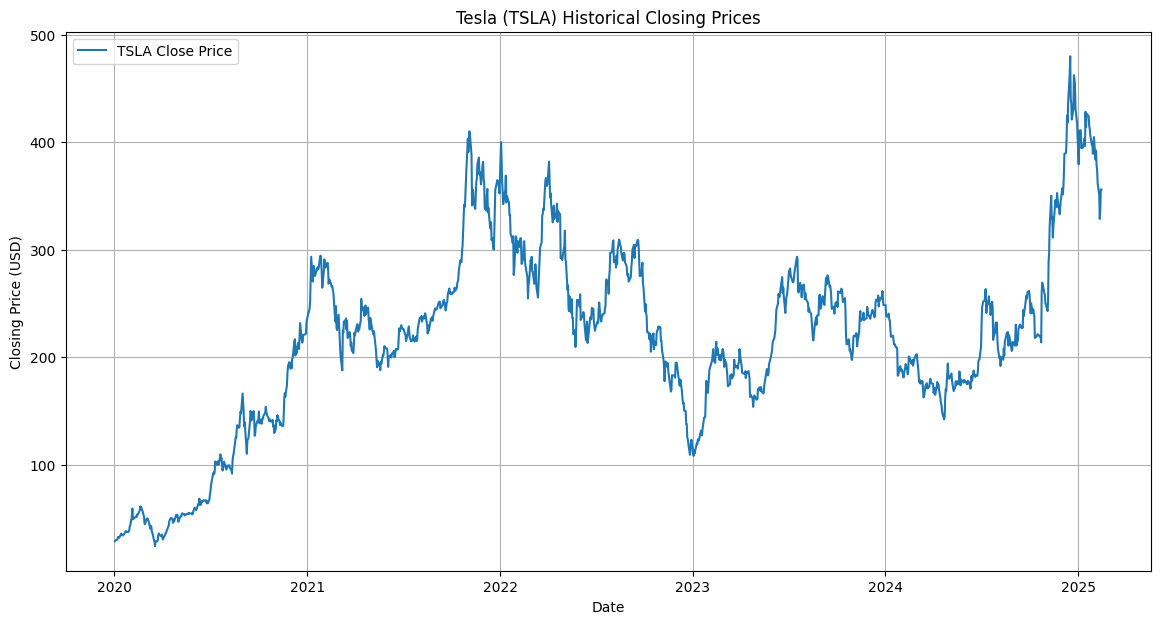

{'ChartGenerator': {'messages': [HumanMessage(content='The investment report for Tesla Inc. (TSLA) has been generated and saved as requested. The historical price chart has also been created, and the report has been saved as a .txt file. You can find the outputs as follows:\n\n- **Investment Report**: `tesla_investment_report.txt`\n- **Historical Price Chart**: `tesla_stock_price.png`\n\nBoth files are saved on disk and ready for review.', additional_kwargs={}, response_metadata={}, name='ChartGenerator')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [ ]:
for s in financial_chain.stream(
    """Write an investment report on {{TESLA}} stock for this {{February, 17th 2025}}. Do a technical analysis and
    a fundamental anaylsis on {{TESLA}}. Also draw a line graph of it the historical price on {{TESLA}},
    IMPORTANT, use the closing price from yfinance for the plot. After that,
    write all into an investment
    report and save it to disk as .txt file.""",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")


# Result Report

# Tesla Stock Investment Report - February 17, 2025

## Executive Summary

Tesla Inc. (TSLA) remains a pivotal company in the automotive and energy sectors, consistently capturing investor interest. This report provides a detailed analysis of Tesla's technical and fundamental aspects as of February 17, 2025, to aid investment decisions.

## Technical Analysis

### Price Trend Analysis

Tesla's stock has shown significant volatility. Despite a 69% increase since late October 2024, the stock has recently retraced, experiencing a 13% decline in 2025. These fluctuations are influenced by broader market reactions and investor sentiment.

### Moving Averages

The moving averages, with the 10-day at \$361.75, 30-day at $390.60, short-term at \$384.57, and long-term at \$401.92, suggest a bearish outlook. The 50-day moving average crossing below the 200-day moving average forms a "death cross," signaling potential downside momentum.

### RSI (Relative Strength Index)

The RSI for Tesla is at 35.54, indicating a neutral position but leaning towards oversold territory. This suggests the stock might be undervalued and could experience a rebound, yet broader market conditions must be considered.

### MACD (Moving Average Convergence Divergence)

The MACD value of -12.42, with a signal line of 0.0, confirms a bearish trend. The MACD indicates a negative divergence, aligning with the bearish moving average crossover.

## Fundamental Analysis

### Financial Performance

Tesla's recent financial performance shows robust revenue growth but declining profit margins due to rising production costs and supply chain disruptions. The company reported a year-over-year revenue growth of 0.95%, while net income declined by 52.46%.

### Valuation Metrics

- **P/E Ratio:** 175.29 (High, indicating potential overvaluation or high growth expectations)
- **Market Cap:** \$1.14 trillion
- **Enterprise Value:** $1.12 trillion

Despite high valuation metrics, Tesla's leadership in electric vehicles and its innovative contributions to sustainable energy solutions remain attractive to investors.

### Market Position & Competitive Analysis

Tesla maintains its leadership position in the electric vehicle market, bolstered by a strong brand and loyal customer base. Its advancements in battery technology and autonomous driving position it well against traditional automakers and new EV entrants. However, the increasing competitive landscape poses a challenge.

## Historical Price Graph

![Tesla Historical Price](https://drive.google.com/uc?export=view&id=1hTQwSBSCBOIfESK6sVB-KAuX3JvRKi9l)


## Conclusion and Recommendations

While technical indicators suggest a bearish trend, Tesla's fundamental strengths and market position present a balanced investment opportunity. Investors should monitor market conditions and assess Tesla's financial health before making decisions.

## Actionable Insights

- **Long-term Investors:** Consider maintaining positions, focusing on Tesla's potential growth in the energy sector.
- **Short-term Traders:** Exercise caution due to volatility and implement risk management strategies, such as stop-loss orders.
- **Potential Investors:** Await further confirmation of trend reversals before initiating new positions.

This report encapsulates Tesla's current investment landscape.




In [ ]:
yf.download(['MSFT'], period='1mo')

/tmp/ipython-input-767111595.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(['MSFT'], period='1mo')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-08-25,504.260010,508.190002,504.119995,506.630005,21638600
2025-08-26,502.040009,504.980011,498.510010,504.359985,30835700
2025-08-27,506.739990,507.290009,499.899994,502.000000,17277900
2025-08-28,509.640015,511.089996,505.500000,507.089996,18015600
2025-08-29,506.690002,509.600006,504.489990,508.660004,20961600
2025-09-02,505.119995,506.000000,496.809998,500.470001,18128000
2025-09-03,505.350006,507.790009,502.320007,503.790009,16345100
2025-09-04,507.970001,508.149994,503.149994,504.299988,15509500


In [ ]:
!pip install yahooquery


In [ ]:
from yahooquery import Ticker

aapl = Ticker('AAPL')
data = aapl.history(period="1y")
print(data.tail())


                         open        high         low       close     volume  \
symbol date                                                                    
AAPL   2025-09-17  238.970001  240.100006  237.729996  238.990005   46508000   
       2025-09-18  239.970001  241.199997  236.649994  237.880005   44249600   
       2025-09-19  241.229996  246.300003  240.210007  245.500000  163741300   
       2025-09-22  248.300003  256.640015  248.119995  256.079987  105517400   
       2025-09-23  255.880005  257.339996  253.580002  254.429993   60232300   

                     adjclose  dividends  
symbol date                               
AAPL   2025-09-17  238.990005        0.0  
       2025-09-18  237.880005        0.0  
       2025-09-19  245.500000        0.0  
       2025-09-22  256.079987        0.0  
       2025-09-23  254.429993        0.0  
